In [1]:
# Install required packages (run once per environment)
import sys
!{sys.executable} -m pip install -q tensorflow scikit-learn matplotlib seaborn

In [2]:
# Imports and environment checks
import os, glob, random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs available:', gpus)
seed = 42
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

# Classes
CLASS_NAMES = ['cbsd', 'cmd', 'healthy']
class_to_index = {name: i for i, name in enumerate(CLASS_NAMES)}

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPUs available: []


In [3]:
# Configuration
DATA_DIR = os.path.join('.', 'D:\\Desktop\\cassava_images\\cleaned_images')  # folder with images or subfolders
IMG_SIZE = 224
BATCH_SIZE = 32
VAL_TEST_FRACTION = 0.2  # used if subfolders exist; split into val+test later
AUGMENT = True

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f'Expected data folder at: {DATA_DIR}')
else:
    print('Found data folder:', os.path.abspath(DATA_DIR))

Found data folder: D:\Desktop\cassava_images\cleaned_images


In [4]:
# Dataset loader supporting two layouts:
# 1) cleaned images/cmd, cleaned images/cbsd, cleaned images/healthy (recommended)
# 2) cleaned images/*.jpg with filenames starting with 'cmd', 'cbsd', or 'healthy'
from tensorflow.data import AUTOTUNE

def build_datasets_via_subfolders():
    print('Loading via subfolders...')
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        class_names=CLASS_NAMES,
        label_mode='int',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        validation_split=VAL_TEST_FRACTION,
        subset='training',
        seed=seed
    )
    val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        class_names=CLASS_NAMES,
        label_mode='int',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        validation_split=VAL_TEST_FRACTION,
        subset='validation',
        seed=seed
    )
    # Split validation into val + test (50/50)
    val_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
    half = max(1, val_batches // 2)
    val_ds = val_test_ds.take(half)
    test_ds = val_test_ds.skip(half)
    return train_ds, val_ds, test_ds

def label_from_path_tensor(fp):
    # Match filenames that START WITH the class prefix and are .jpg
    fp = tf.strings.lower(fp)
    fname = tf.strings.regex_replace(fp, r'.*[\\/]', '')  # basename only
    is_cbsd = tf.strings.regex_full_match(fname, r'cbsd.*\.jpg')
    is_cmd = tf.strings.regex_full_match(fname, r'cmd.*\.jpg')
    is_healthy = tf.strings.regex_full_match(fname, r'healthy.*\.jpg')
    # Align indices with CLASS_NAMES = ['cbsd', 'cmd', 'healthy'] -> 0, 1, 2
    label = tf.where(is_cbsd, 0, tf.where(is_cmd, 1, tf.where(is_healthy, 2, -1)))
    return tf.cast(label, tf.int32)

def decode_and_resize(fp):
    img = tf.io.read_file(fp)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    return img

def parse_example(fp):
    img = decode_and_resize(fp)
    label = label_from_path_tensor(fp)
    return img, label

def build_datasets_via_filenames():
    print('Loading via filenames...')
    exts = ('.jpg',)  # only JPG images
    files = [f for f in glob.glob(os.path.join(DATA_DIR, '*'))
             if os.path.isfile(f) and f.lower().endswith(exts)]
    # Keep only files whose basename starts with one of the class prefixes
    files = [f for f in files if os.path.basename(f).lower().startswith(tuple(CLASS_NAMES))]
    if len(files) == 0:
        raise RuntimeError('No labeled .jpg images found. Filenames must start with cbsd/cmd/healthy.')
    random.Random(seed).shuffle(files)
    n = len(files)
    test_count = max(1, n // 10)
    val_count = max(1, n // 10)
    train_count = n - val_count - test_count
    train_files = files[:train_count]
    val_files = files[train_count:train_count+val_count]
    test_files = files[train_count+val_count:]
    def make_ds(file_list):
        ds = tf.data.Dataset.from_tensor_slices(file_list)
        ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        return ds
    train_ds = make_ds(train_files)
    val_ds = make_ds(val_files)
    test_ds = make_ds(test_files)
    return train_ds, val_ds, test_ds

# Decide which loader to use
has_subdirs = all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in CLASS_NAMES)
train_ds, val_ds, test_ds = (build_datasets_via_subfolders() if has_subdirs else build_datasets_via_filenames())

# Optional augmentation
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
]) if AUGMENT else None

def prepare(ds, training=False):
    ds = ds.cache()
    if training and augmentation is not None:
        ds = ds.map(lambda x, y: (augmentation(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

print('Dataset ready.')

Loading via subfolders...
Found 4290 files belonging to 3 classes.
Using 3432 files for training.
Found 4290 files belonging to 3 classes.
Using 858 files for validation.
Dataset ready.


In [6]:
# Build MobileNetV2 baseline model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=x)
base.trainable = False  # freeze for baseline
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12176\4191521856.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=x)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


108/108 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.6518 - loss: 0.7680 - val_accuracy: 0.7716 - val_loss: 0.5625
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 470s 4s/step - accuracy: 0.7759 - loss: 0.5361 - val_accuracy: 0.7812 - val_loss: 0.5369
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.7998 - loss: 0.4922 - val_accuracy: 0.8125 - val_loss: 0.4408
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.8167 - loss: 0.4453 - val_accuracy: 0.8269 - val_loss: 0.4169
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.8281 - loss: 0.4208 - val_accuracy: 0.8293 - val_loss: 0.4049
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.8316 - loss: 0.4079 - val_accuracy: 0.8413 - val_loss: 0.3876
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8418 - loss: 0.4067 - val_accuracy: 0.8269 - val_loss: 0.4197
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8342 - loss: 0.4084 - val_accuracy: 0.848

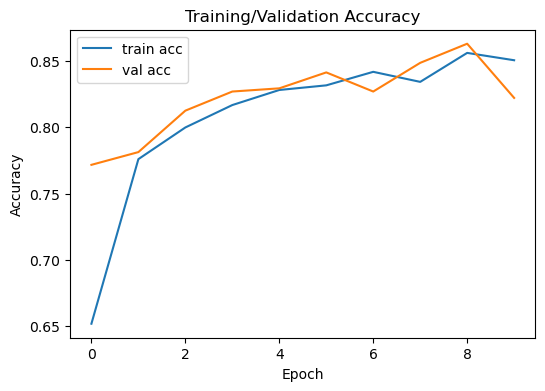

In [7]:
# Train
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

# Plot accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Validation Accuracy')
plt.show()

              precision    recall  f1-score   support

        cbsd       0.79      0.84      0.82       148
         cmd       0.96      0.80      0.87       139
     healthy       0.81      0.88      0.84       155

    accuracy                           0.84       442
   macro avg       0.85      0.84      0.84       442
weighted avg       0.85      0.84      0.84       442



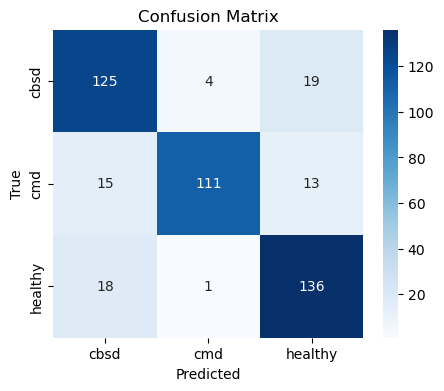

In [8]:
# Evaluate on test set
y_true = []
y_pred = []
for batch in test_ds:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fine-tuning: unfreeze top layers for higher accuracy

Fine-tuning improves performance by training the top convolutional layers of the pretrained base with a lower learning rate while keeping BatchNorm layers frozen for stability.

Steps:
- Unfreeze ~30 top layers (except BatchNormalization)
- Recompile with a lower learning rate (1e-4)
- Train for a few more epochs


Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.8054 - loss: 0.4706 - val_accuracy: 0.8774 - val_loss: 0.3131
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.8773 - loss: 0.3068 - val_accuracy: 0.8894 - val_loss: 0.2930
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9175 - loss: 0.2135 - val_accuracy: 0.8918 - val_loss: 0.3499
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.9277 - loss: 0.1953 - val_accuracy: 0.9014 - val_loss: 0.2691
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.9443 - loss: 0.1473 - val_accuracy: 0.9231 - val_loss: 0.2449


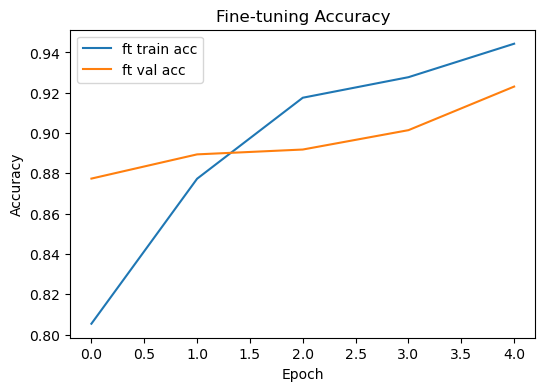

In [9]:
# Unfreeze top layers (except BatchNorm) and fine-tune
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

# First, keep everything frozen
for layer in base.layers:
    layer.trainable = False

# Unfreeze the last ~30 layers except BatchNorm for stability
for layer in base.layers[-30:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Recompile with a lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for a few epochs
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)

# Optional: visualize fine-tuning accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(fine_tune_history.history['accuracy'], label='ft train acc')
plt.plot(fine_tune_history.history['val_accuracy'], label='ft val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Fine-tuning Accuracy')
plt.show()

              precision    recall  f1-score   support

        cbsd       0.96      0.90      0.93       148
         cmd       0.98      0.93      0.96       139
     healthy       0.87      0.97      0.92       155

    accuracy                           0.93       442
   macro avg       0.94      0.93      0.93       442
weighted avg       0.94      0.93      0.93       442



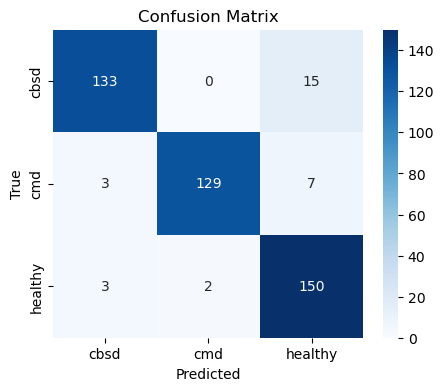

In [10]:
# Evaluate on test set
y_true = []
y_pred = []
for batch in test_ds:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Save the trained model
save_path = 'cassava_baseline_mobilenetv2.keras'
model.save(save_path)
print('Model saved to', os.path.abspath(save_path))

Model saved to d:\Desktop\Git\vscode-git\cassava_baseline_mobilenetv2.keras
